# Convolutional Autoencoder (PyTorch)

In [1]:
import os
import pickle
from urllib.request import urlopen
import numpy as np

import torch
import torchvision
from torchvision import transforms
import torchvision.datasets as datasets

# ConvAE
import ConvAE_AutoConf as ConvAE

import matplotlib.pyplot as plt
%matplotlib inline

import matplotlib as mpl
mpl.rcParams['axes.grid'] = False
mpl.rcParams['image.interpolation'] = 'nearest'
mpl.rcParams['figure.figsize'] = 15, 25

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
# !wget http://cs231n.stanford.edu/tiny-imagenet-200.zip
# !unzip tiny-imagenet-200.zip

In [3]:
# !wget --no-check-certificate --content-disposition https://github.com/yrevar/ai_playground/blob/master/ImageNet/imagenet1000_clsid_to_labels.pkl

In [4]:
with open("imagenet1000_clsid_to_labels.pkl", "rb") as file:
    clsid_to_labels = pickle.load(file)
clsid_to_labels = {k: v.split(", ") for k,v in clsid_to_labels.items()}

## Dataset: Tiny ImageNet 
Courtesy: https://tiny-imagenet.herokuapp.com/

In [5]:
np.random.seed(0)
torch.manual_seed(0)

data = "tiny-imagenet-200"
batch_size = 32
workers = 4
distributed = False

# Data loading code
traindir = os.path.join(data, 'train')
valdir = os.path.join(data, 'val')
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])
class NormalizeInverse(torchvision.transforms.Normalize):
    """
    Ref: https://discuss.pytorch.org/t/simple-way-to-inverse-transform-normalization/4821
    Undoes the normalization and returns the reconstructed images in the input domain.
    """

    def __init__(self, mean, std):
        mean = torch.as_tensor(mean)
        std = torch.as_tensor(std)
        std_inv = 1 / (std + 1e-7)
        mean_inv = -mean * std_inv
        super().__init__(mean=mean_inv, std=std_inv)

    def __call__(self, tensor):
        return super().__call__(tensor.clone())
inv_normalize = NormalizeInverse(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])

# Ref: https://pytorch.org/docs/stable/torchvision/transforms.html

train_dataset = datasets.ImageFolder(
    traindir,
    transforms.Compose([
        transforms.RandomResizedCrop(64),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        normalize,
    ]))

if distributed:
    train_sampler = torch.utils.data.distributed.DistributedSampler(train_dataset)
else:
    train_sampler = None

train_loader = torch.utils.data.DataLoader(
        train_dataset, batch_size=batch_size, shuffle=(train_sampler is None),
        num_workers=workers, pin_memory=True, sampler=train_sampler)

val_loader = torch.utils.data.DataLoader(
    datasets.ImageFolder(valdir, transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        normalize,
    ])),
    batch_size=batch_size, shuffle=False,
    num_workers=workers, pin_memory=True)

input_dim = io.imread(train_dataset.imgs[0][0]).transpose(2,0,1).shape
nw_input_dim = (batch_size,) + input_dim

## Visualization of raw input

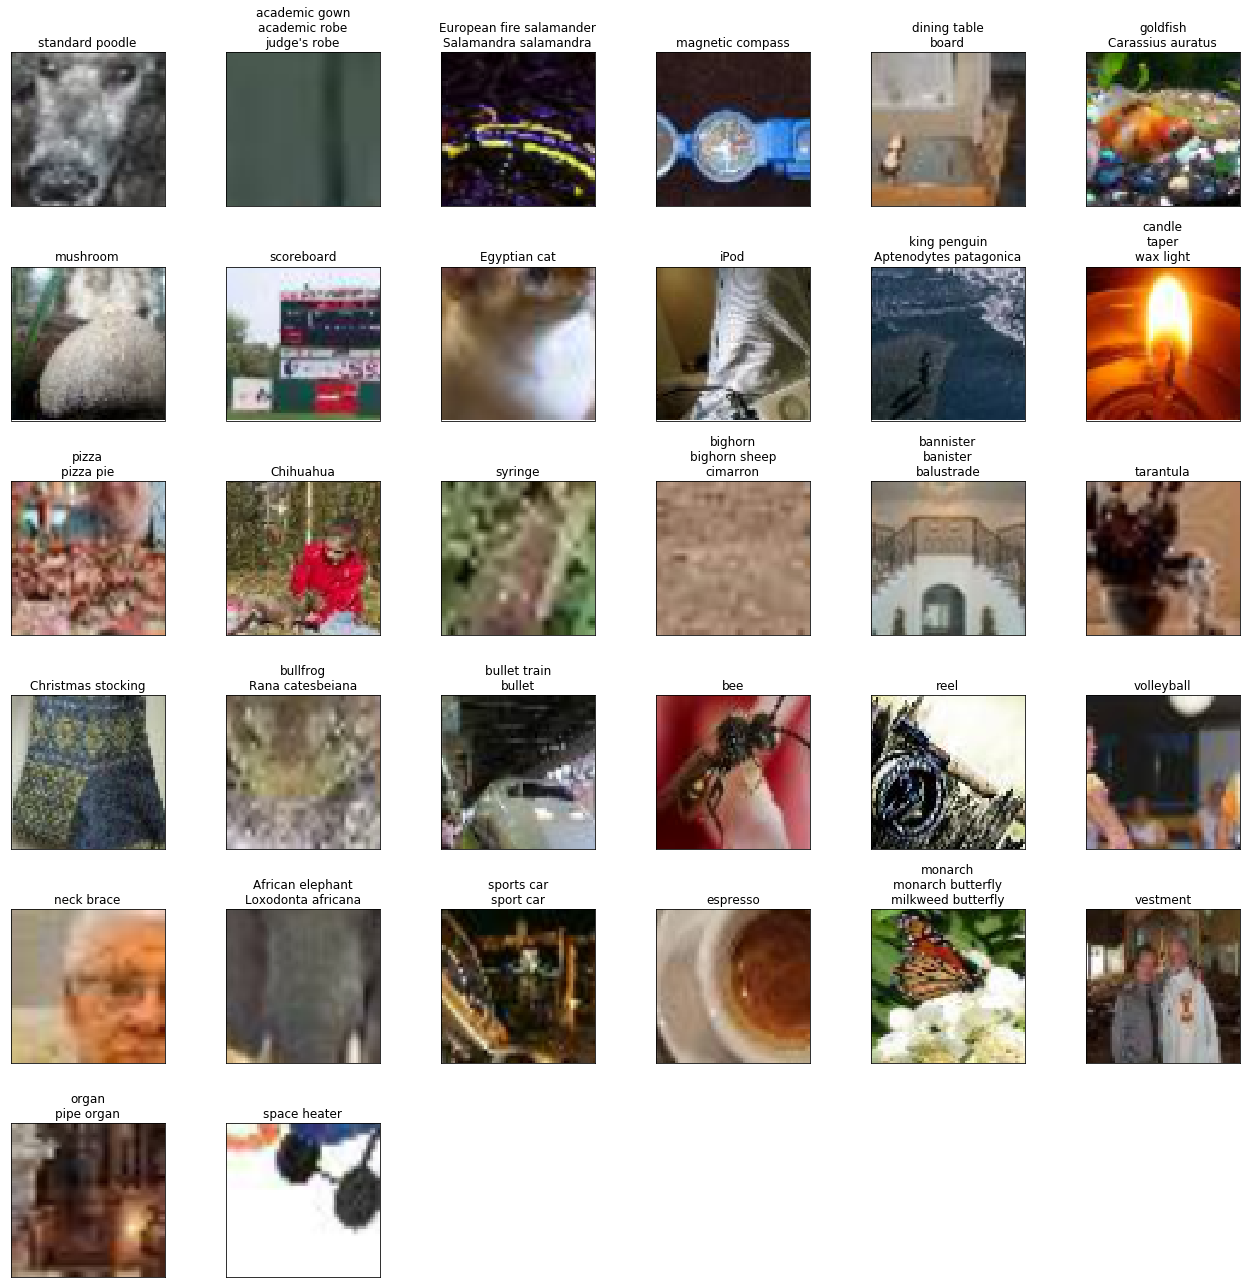

In [6]:
X, y = iter(train_loader).next()
plt.figure(figsize=(18,18))
for i in range(len(X)):
    plt.subplot(6,6,i+1)
    plt.imshow(torch.clamp(inv_normalize(X[i]), 0, 1).permute(1,2,0))
    plt.title("{}".format("\n".join(clsid_to_labels[train_dataset.classes[y[i].item()]][:3])))
    plt.xticks([]), plt.yticks([])
plt.tight_layout()

## Convolutional Autoencoder

In [8]:
feature_maps = 8
depth = 8
pooling_freq = 1e100 # large number to disable pooling layers
batch_norm_freq = 2
strided_conv_freq = 2
strided_conv_feature_maps = 8
code_size = 8

CONV_ENC_BLOCK = [("conv1", feature_maps), ("relu1", None)]
CONV_ENC_LAYERS = ConvAE.create_network(
    CONV_ENC_BLOCK, depth, 
    pooling_freq=pooling_freq,
    strided_conv_freq=strided_conv_freq, 
    strided_conv_channels=strided_conv_feature_maps,
    batch_norm_freq=batch_norm_freq)

CONV_ENC_NW = CONV_ENC_LAYERS + [("flatten1", None), ("linear1", 8)]
model = ConvAE.ConvAE(input_dim, enc_config=CONV_ENC_NW, store_activations=False)
# print("Encoder Nw Spec:")
# CONV_ENC_NW
print(model)

ConvAE(
  (encoder): ModuleList(
    (0): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): ReLU()
    (2): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (3): ReLU()
    (4): Conv2d(8, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (5): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (7): ReLU()
    (8): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (9): ReLU()
    (10): Conv2d(8, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (11): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (13): ReLU()
    (14): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (15): ReLU()
    (16):

In [9]:
out, code = model(X)

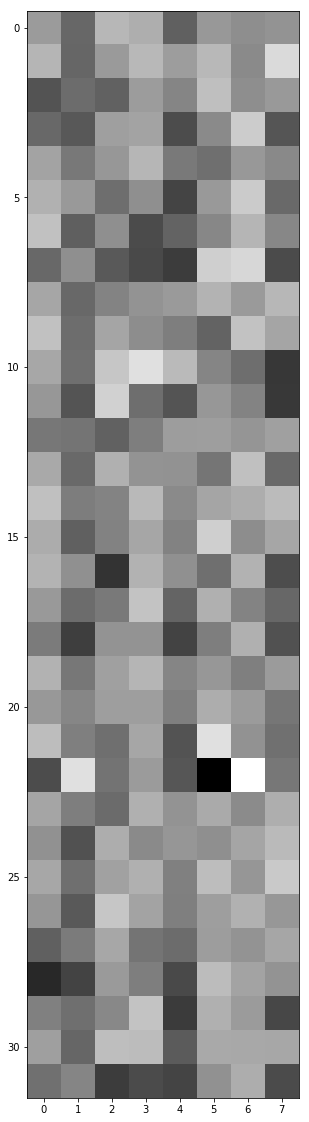

In [10]:
plt.figure(figsize=(20,20))
plt.imshow(code.detach().numpy(), cmap="gray")

In [11]:
out_normalized = torch.clamp(
    model.get_results_img(torch.stack([inv_normalize(img.detach()) for img in X]), 
                                       torch.stack([inv_normalize(img.detach()) for img in out])), 0, 1)

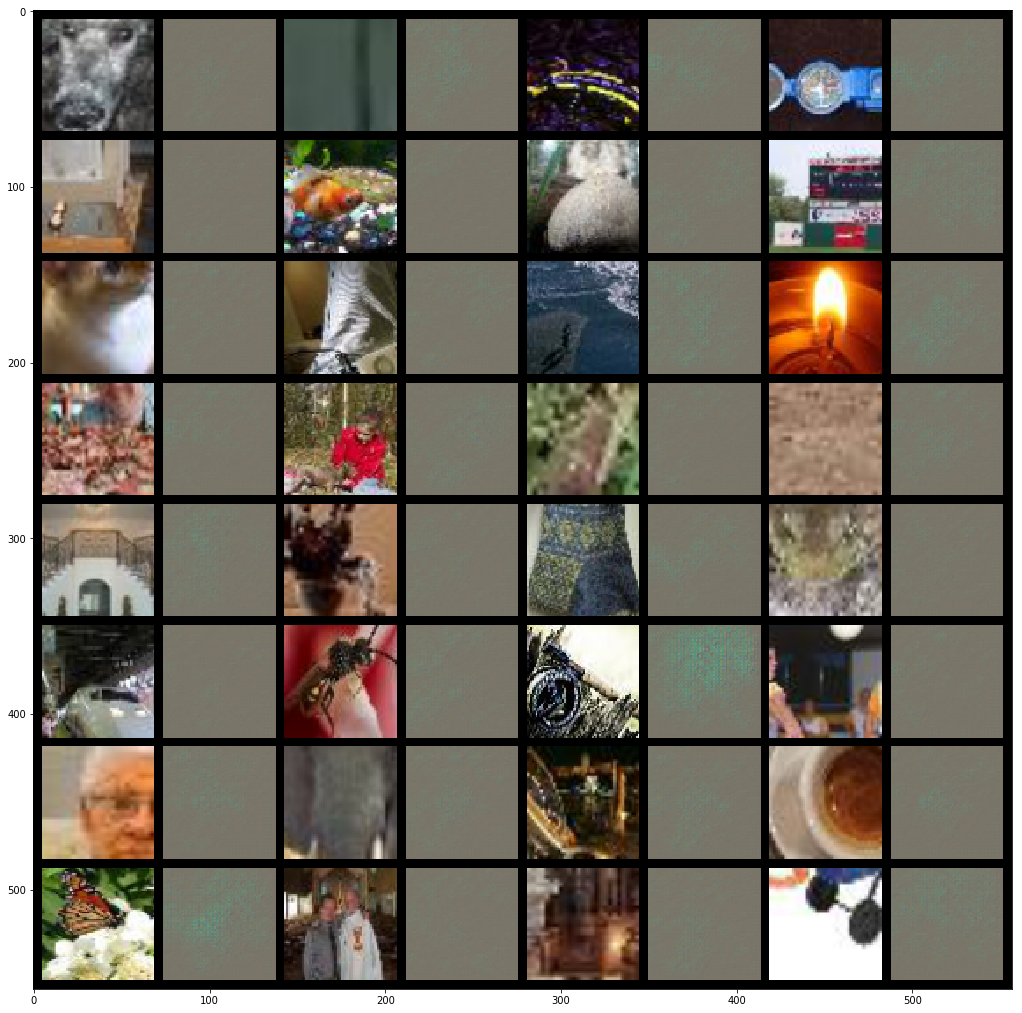

In [12]:
plt.figure(figsize=(18,18))
plt.imshow(out_normalized.detach())

Credits:
    
1. https://colab.research.google.com/drive/12MpOaxe29FPFU_Vi1FLkPL8fL5FdvOC5#scrollTo=u6o2H9qAjkZg
2. Xingyu Liao. https://github.com/L1aoXingyu/pytorch-beginner/blob/master/08-AutoEncoder/conv_autoencoder.py
3. Danylo Ulianych. https://discuss.pytorch.org/t/simple-way-to-inverse-transform-normalization/4821
4. https://tiny-imagenet.herokuapp.com/